### Importing the necessary libraries

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-5j22mexp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-5j22mexp
  Resolved https://github.com/facebookresearch/detectron2.git to commit 400a49c1ec11a18dd25aea3910507bc3bcd15794
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.7 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os, sys, cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog

### Setting up cfg for the models

In [27]:
def setup_cfg(weights_path, config_file, num_classes, output_dir,
              num_workers=2, mask_format=None,
              backbone_freeze_at=1,
              batch_size_per_image=128,
              max_iter=1000):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_file))
    cfg.MODEL.WEIGHTS = weights_path
    cfg.DATALOADER.NUM_WORKERS = num_workers
    if mask_format:
        cfg.INPUT.MASK_FORMAT = mask_format
    cfg.INPUT.MIN_SIZE_TRAIN = (512,)
    cfg.INPUT.MAX_SIZE_TRAIN = 512
    cfg.INPUT.MIN_SIZE_TEST = 512
    cfg.INPUT.MAX_SIZE_TEST = 512
    cfg.INPUT.RANDOM_FLIP = "none"
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.BACKBONE.FREEZE_AT = backbone_freeze_at
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.SOLVER.AMP.ENABLED = True
    cfg.SOLVER.BASE_LR = 1e-4
    cfg.SOLVER.IMS_PER_BATCH = 32
    cfg.CUDNN_BENCHMARK = True
    cfg.OUTPUT_DIR = output_dir
    os.makedirs(output_dir, exist_ok=True)
    return cfg

### Taking in the image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

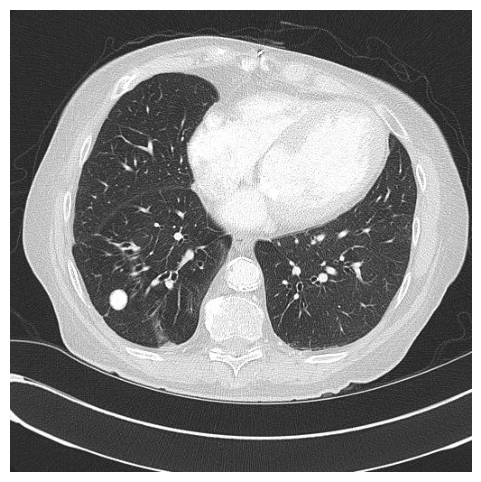

In [42]:
image_path = "/content/drive/MyDrive/Lungs.jpg"
im = cv2.imread(image_path)
h, w = im.shape[:2]
scale = min(512 / w, 512 / h, 1.0)
new_w, new_h = int(w * scale), int(h * scale)
resized = cv2.resize(im, (new_w, new_h))

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))
plt.axis('off')

### Segmenting the image

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

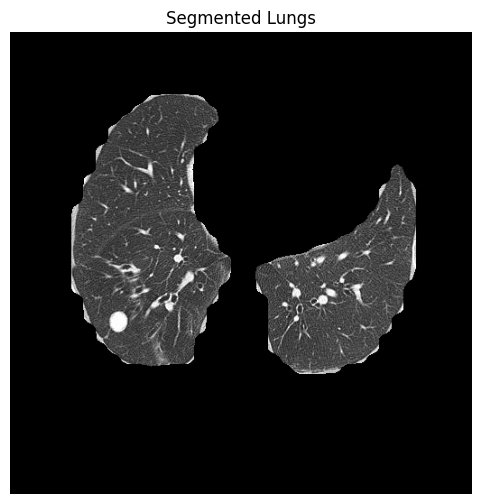

In [43]:
seg_cfg = setup_cfg(
        weights_path="/content/drive/MyDrive/Lung_Cancer/Lung_Segmentation/V13/LungSegmentationOutput/model_final.pth",
        config_file="Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml",
        num_classes=1,
        output_dir="./Segmentation_output",
        num_workers=2,
        mask_format="bitmask",
        backbone_freeze_at=1,
        batch_size_per_image=128,
        max_iter=2000
    )
seg_pred = DefaultPredictor(seg_cfg)
outputs = seg_pred(im)
instances = outputs['instances'].to('cpu')
seg_mask = instances.pred_masks.numpy()
combined_mask = np.any(seg_mask, axis=0).astype(np.uint8)
seg_img = im * combined_mask[:, :, None]

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB))
plt.title("Segmented Lungs")
plt.axis('off')

### Predicting 5 Radiological Features

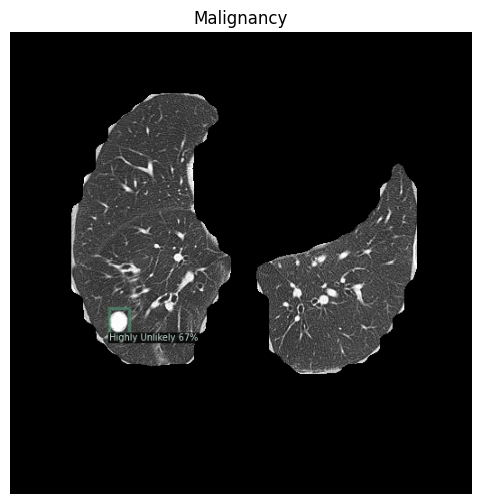

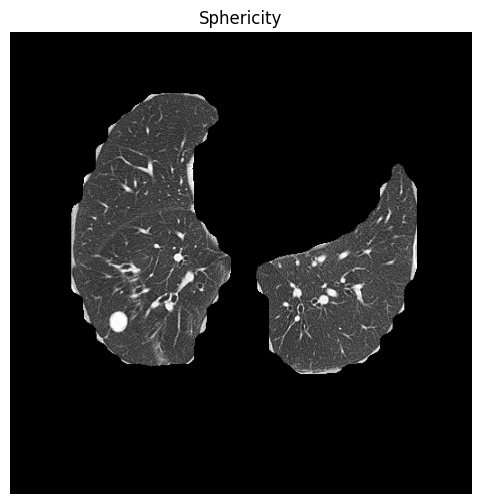

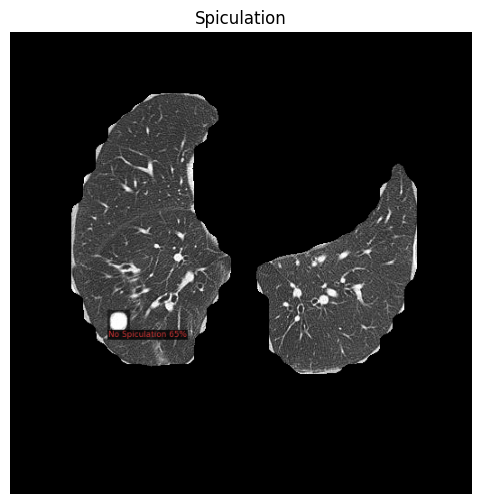

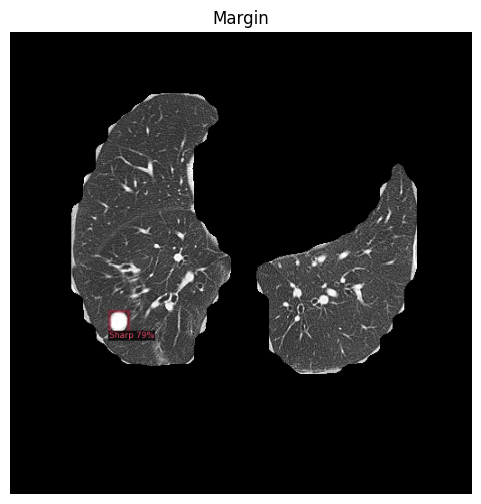

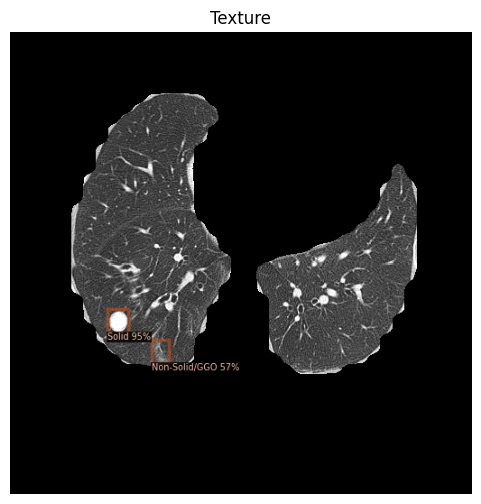

In [44]:
features = [
    ("Malignancy","MalignancyOutput"),
    ("Sphericity","SphericityOutput"),
    ("Spiculation","SpiculationOutput"),
    ("Margin","MarginOutput"),
    ("Texture","TextureOutput"),
]
category_map = {
    "Sphericity": [
        "Linear",
        "Ovoid/Linear",
        "Ovoid",
        "Ovoid/Round",
        "NA",
    ],
    "Margin": [
        "Poorly Defined",
        "Near Poorly Defined",
        "Medium Margin",
        "Near Sharp",
        "Sharp",
    ],
    "Texture": [
        "Non-Solid/GGO",
        "Non-Solid/Mixed",
        "Part Solid/Mixed",
        "Solid/Mixed",
        "Solid",
    ],
    "Malignancy": [
        "Highly Unlikely",
        "Moderately Unlikely",
        "Indeterminate",
        "Moderately Suspicious",
        "Highly Suspicious",
    ],
    "Spiculation": [
        "No Spiculation",
        "Nearly No Spiculation",
        "Medium Spiculation",
        "Near Marked Spiculation",
        "Marked Spiculation",
    ],
}

results = {}
for name, folder in features:
    weights = f"/content/drive/MyDrive/Lung_Cancer/V3/{name}Output/model_final.pth"
    cfg = setup_cfg(
        weights_path=weights,
        config_file="COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
        num_classes=5,
        output_dir=f"./{folder}",
        num_workers=32,
        backbone_freeze_at=2,
        batch_size_per_image=256,
        max_iter=1000
    )
    pred = DefaultPredictor(cfg)
    out = pred(seg_img)
    results[name] = out
    dataset_name = f"{name}_inference"
    if dataset_name not in DatasetCatalog.list():
        DatasetCatalog.register(dataset_name, lambda: [])
    MetadataCatalog.get(dataset_name).set(thing_classes=category_map[name])
    metadata = MetadataCatalog.get(dataset_name)
    seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)
    v = Visualizer(
        seg_img_rgb,
        metadata,
        scale=1.0
    )
    vis = v.draw_instance_predictions(out["instances"].to("cpu"))
    plt.figure(figsize=(6, 6))
    plt.imshow(vis.get_image())
    plt.title(name)
    plt.axis('off')


In [45]:
final_predictions = {}
for name, out in results.items():
    inst = out["instances"].to("cpu")
    if len(inst) == 0:
        final_predictions[name] = "No detection"
    else:
        scores = inst.scores.numpy()
        classes = inst.pred_classes.numpy().astype(int)
        best = scores.argmax()
        final_predictions[name] = category_map[name][classes[best]]

print(final_predictions)

{'Malignancy': 'Highly Unlikely', 'Sphericity': 'No detection', 'Spiculation': 'No Spiculation', 'Margin': 'Sharp', 'Texture': 'Solid'}
